In [1]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


In [2]:
bioclim = pd.read_csv('data/csv/bioclim.csv')
bioclim = bioclim.drop(columns=['Unnamed: 0'])

crta_coords_filtered = pd.read_csv('data/csv/crta_coords_filtered.csv')
crta_coords_filtered.columns = ['lat', 'lon']
bioclim = pd.merge(bioclim, crta_coords_filtered, on=['lat', 'lon'])
bioclim = bioclim.drop_duplicates(subset=['lat', 'lon'])
bioclim = bioclim[bioclim['bio_13']!=-3.4e+38]
bioclim.columns


Index(['lat', 'lon', 'bio_13', 'bio_11', 'bio_9', 'bio_3', 'elev', 'bio_5',
       'bio_6', 'bio_17', 'bio_10', 'bio_2', 'bio_15', 'bio_12', 'bio_1',
       'bio_16', 'bio_8', 'bio_4', 'bio_19', 'bio_7', 'bio_14', 'bio_18',
       'ndvi'],
      dtype='object')

In [3]:
coords = bioclim[['lat', 'lon']]
bioclim = bioclim.drop(columns=['lat', 'lon', 'elev'])
#sorted_columns = sorted(bioclim.columns, key=lambda x: int(x.split('_')[1]))
#bioclim = bioclim[sorted_columns]
bioclim = pd.DataFrame(bioclim['bio_1'])
bioclim['group'] = 'osmia'
bioclim


,bio_1,group
0,9.683333,osmia
10,10.008333,osmia
45,9.391666,osmia
46,10.066667,osmia
54,9.758333,osmia
...,...,...
24203,10.029167,osmia
24204,10.333333,osmia
24205,10.687500,osmia
24206,9.800000,osmia


In [4]:
america = pd.read_csv('data/csv/10k_america_bioclim_ndvi.csv', index_col=None)
america = america.drop(columns=['Unnamed: 0'])
america = america[america['bio_13']!= -3.4e+38]
america_points = america[['lat', 'lon']]
america = america.drop(columns=['lat', 'lon', 'elev'])
america = pd.DataFrame(america['bio_1'])
america['group'] = 'america'
column_order = bioclim.columns.tolist()
america = america[column_order]
america


,bio_1,group
0,21.995832,america
1,22.712500,america
2,24.941666,america
3,24.525000,america
4,14.679167,america
...,...,...
6600,-4.612500,america
6601,-4.508333,america
6602,-4.412500,america
6603,-4.462500,america


In [5]:
america.describe()

,bio_1
count,6546.000000
mean,8.395711
std,6.874994
min,-5.608333
25%,2.734375
50%,7.691667
75%,13.614584
max,24.941666


In [6]:
combined = pd.concat([bioclim, america], ignore_index=True)
combined_points = pd.concat([coords, america_points])

In [7]:
combined_vars = combined.drop(columns=['group'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(combined_vars)
combined_scaled = pd.DataFrame(df_scaled, columns=combined_vars.columns)
combined_scaled['group'] = combined['group']

In [8]:
america_df = combined_scaled[combined_scaled['group'] == 'america'].drop('group', axis=1)
osmia_df = combined_scaled[combined_scaled['group'] == 'osmia'].drop('group', axis=1)

In [9]:
combined_scaled.describe()

,bio_1
count,1.289400e+04
mean,1.763407e-16
std,1.000039e+00
min,-2.929109e+00
25%,-3.620686e-01
50%,9.986689e-02
75%,3.060881e-01
max,3.118944e+00


In [10]:
osmia_df

,bio_1
0,0.098217
1,0.162558
2,0.040475
3,0.174107
4,0.113065
...,...
6343,0.166683
6344,0.226899
6345,0.297014
6346,0.121314


In [11]:
from scipy.spatial import distance
from scipy.stats import chi2

osmia_mean = osmia_df.mean()
osmia_cov = osmia_df.cov()

def mahalanobis_distance(x, mean, cov):
    x_minus_mu = x - mean
    cov_inv = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, cov_inv)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.sqrt(mahal)

# Calculating the Mahalanobis distance for each point in the 'america' group
mahal_distances = america_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

In [12]:
osmia_cov

,bio_1
bio_1,0.069804


In [13]:
mahal_distances = mahal_distances.reset_index(drop=True)

In [14]:
mahal_distances_eur = osmia_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

Text(0.5, 1.0, 'distribution of mahal distances, america to eur')

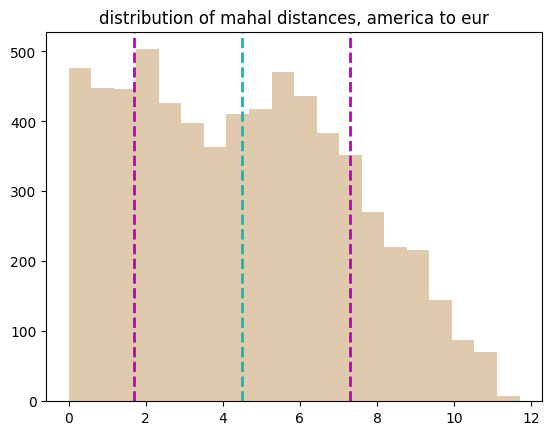

In [15]:
mean = np.mean(mahal_distances)
std_dev = np.std(mahal_distances)

# Create histogram
plt.hist(mahal_distances, bins=20, alpha=0.7, color='tan')

# Mark the mean
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')

# Mark one standard deviation on either side of the mean
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, america to eur')


Text(0.5, 1.0, 'distribution of mahal distances, eur to eur')

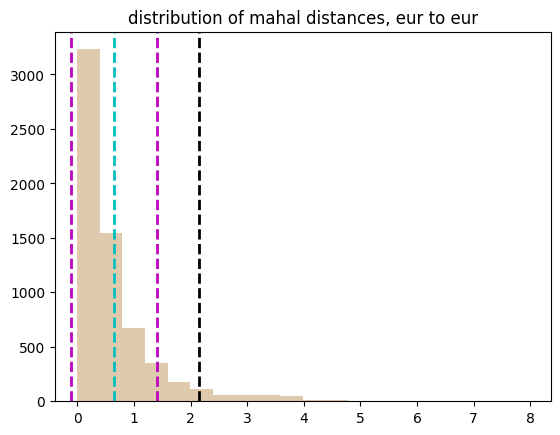

In [16]:
mean = np.mean(mahal_distances_eur)
std_dev = np.std(mahal_distances_eur)
z = 1.96
upper_bound = mean + z * std_dev

plt.hist(mahal_distances_eur, bins=20, alpha=0.7, color='tan')

# Mark the mean
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')

# Mark one standard deviation on either side of the mean
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.axvline(upper_bound, color='k', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, eur to eur')


In [17]:
upper_bound

2.1421049495558857

In [18]:
max(mahal_distances_eur)

7.967157722497606

In [19]:
america_points = america_points.reset_index(drop=True)
america_points['dist'] = mahal_distances
# america_points.to_csv('america_points_mahal.csv')

In [20]:
crta_coords_filtered = crta_coords_filtered.reset_index(drop=True)
mahal_distances_eur = mahal_distances_eur.reset_index(drop=True)

crta_coords_filtered['dist'] = mahal_distances_eur

(-14641852.624039328, -6841695.90415462, 2746944.401339209, 7307496.882081329)

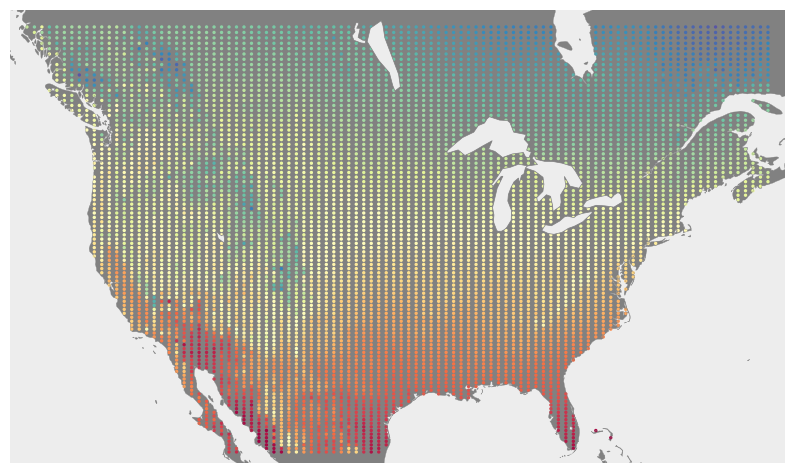

In [21]:
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

extent = [-131.53, -61.46, 24.09, 54.90]

map_projection = ccrs.Mercator() 

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  # Adjust as needed

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')


ax.scatter(america_points['lon'], america_points['lat'], transform=ccrs.PlateCarree(), 
           c=america['bio_1'], cmap='Spectral_r', vmin=-6, vmax = 25, s=2)

ax.axis('off')



In [22]:
crta_coords_filtered

,lat,lon,dist
0,51.024975,13.708278,0.239841
1,51.024975,13.791615,0.003687
2,52.274952,10.541514,0.458392
3,51.074970,13.708281,0.047397
4,50.523056,7.317993,0.183642
...,...,...,...
6489,49.725805,8.126862,NaN
6490,49.494917,8.284069,NaN
6491,49.539502,8.397228,NaN
6492,49.463856,8.164538,NaN


In [23]:
bioclim['bio_1'].describe()

count    6348.000000
mean       10.003413
std         1.334551
min        -0.629167
25%         9.345834
50%         9.887500
75%        10.395833
max        18.087500
Name: bio_1, dtype: float64

KeyError: 'lon'

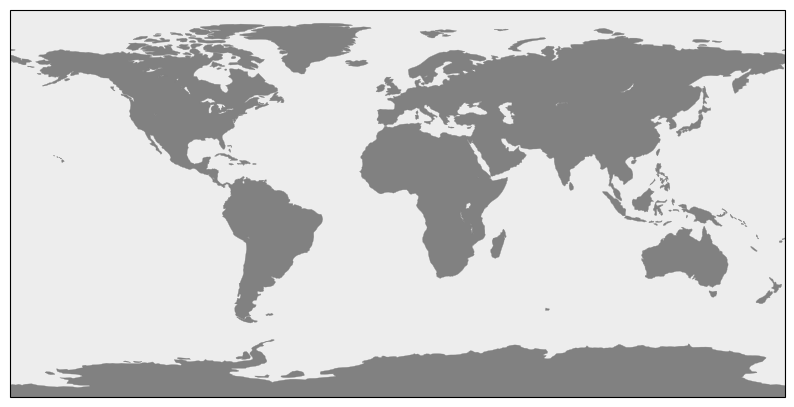

In [24]:
plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(bioclim['lon'], bioclim['lat'], transform=ccrs.PlateCarree(), 
           c=bioclim['bio_1'], s=2, cmap='Spectral_r', vmin=-1, vmax = 18)
ax.axis('off')

# plt.savefig('eur_mahal.png', format='png', dpi=300)

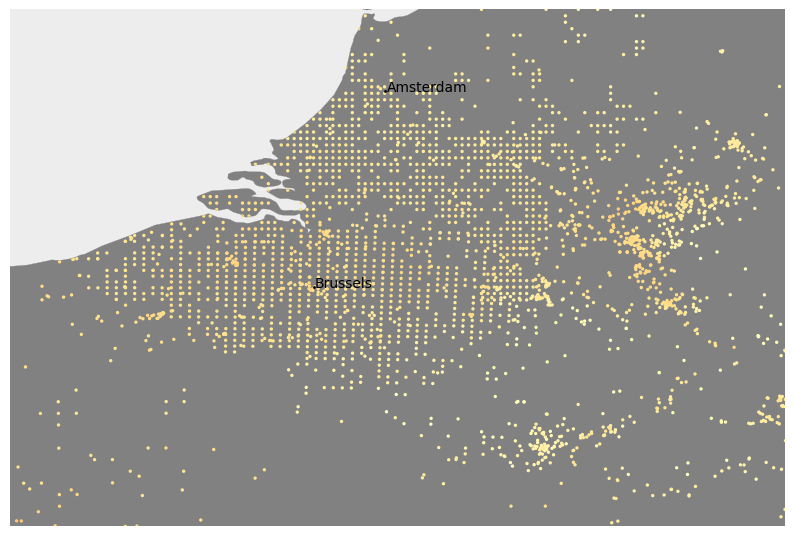

In [ ]:
cities = {
    "Amsterdam": (52.3676, 4.9041),
    "Brussels": (50.8503, 4.3517),
}

plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

extent = [2, 8, 49, 53]

ax.set_extent(extent, crs=ccrs.PlateCarree())  # Adjust as needed
ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(bioclim['lon'], bioclim['lat'], transform=ccrs.PlateCarree(), 
           c=bioclim['bio_1'], s=2, cmap='Spectral_r', vmin=-1, vmax = 18)
ax.axis('off')


for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'o', markersize=1, color='k', transform=ccrs.Geodetic())
    ax.text(lon + .01, lat + 0, city, transform=ccrs.Geodetic())


In [ ]:
combined_df = combined_scaled.drop(columns=['group'])

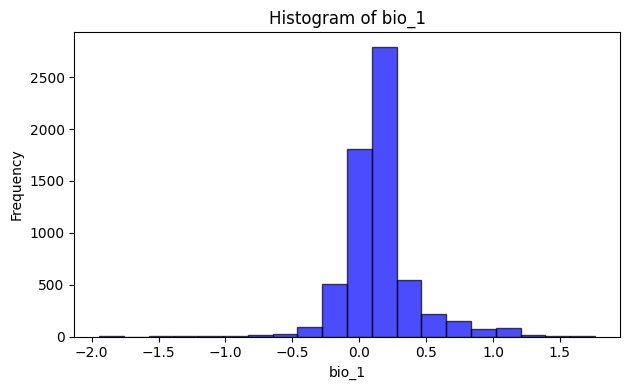

In [ ]:

n_cols = osmia_df.shape[1] # Number of variables
n_rows = (n_cols + 1) // 2  # Arrange plots in a 2-column layout

# Adjust the size of the overall figure as needed
plt.figure(figsize=(12, 4 * n_rows))

# Loop through each column and plot
for i, column in enumerate(osmia_df.columns):
    plt.subplot(n_rows, 2, i + 1)
    plt.hist(osmia_df[column], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout for better viewing
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import normaltest

results = {}
for column in combined_df.columns:
    k2, p = normaltest(combined_df[column].dropna())  # dropna() is used to remove missing values
    results[column] = {'K2 Statistic': k2, 'P-Value': p, 'Normality': p > 0.05}


for key, value in results.items():
    print(value)



{'K2 Statistic': 170.4282918978466, 'P-Value': 9.816725207756777e-38, 'Normality': False}


In [ ]:
import pingouin as pg

In [ ]:
bioclim_df = bioclim.drop(columns=['group'])

KeyError: "['group'] not found in axis"

In [ ]:
combined_no_group = combined.drop(columns=['group'])

In [ ]:
result = pg.multivariate_normality(combined_no_group, alpha=.05)
print(result)

AssertionError: X must have at least two columns.

NameError: name 'stats' is not defined

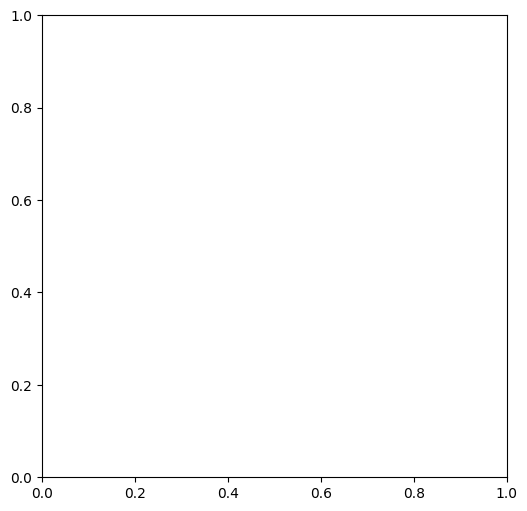

In [ ]:
for column in combined_df.columns:
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    stats.probplot(combined_df[column], dist="norm", plot=ax)
    ax.set_title(f"Q-Q plot for {column}")
    plt.show()
